In [1]:
import sys
import math

from PIL import Image

import numpy as np
from bisect import bisect_left

from pyvox.models import Vox
from pyvox.writer import VoxWriter
from pyvox.parser import VoxParser

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

from pprint import pprint

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bezier_gradient(ref_colors, output_num=100):
    n_ref = len(ref_colors) - 1

    fact_cache = {}
    def fact(n):
        ''' Memorized factorial function '''
        try:
            return fact_cache[n]
        except(KeyError):
            if n == 1 or n == 0:
                result = 1
            else:
                result = n*fact(n-1)
            fact_cache[n] = result
            return result

    def bernstein(t, n, i):
        ''' Bernstein coefficient '''
        binom = fact(n)/float(fact(i)*fact(n - i))
        return binom*((1-t)**(n-i))*(t**i)

    def bezier_interp(t):
            ''' Define an interpolation function
                for this specific curve'''
            # List of all summands
            summands = [
                list(map(lambda x: int(bernstein(t, n_ref, i)*x), c)) for i, c in enumerate(ref_colors)
            ]

            # Output color
            out = [0,0,0]
            # Add components of each summand together
            for vector in summands:
                for c in range(3):
                    out[c] += vector[c]

            return out

    gradient = [
        bezier_interp(float(t)/(output_num-1)) for t in range(output_num)
    ]
    return gradient

In [3]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]


def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
        colors in RGB and hex form for use in a graphing function
        defined later on '''
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def control_points_from_colors(gradient):
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def plot_gradient_series(color_dict, pointsize=100, control_points=None, filename=None):
        ''' Take a dictionary containing the color
            gradient in RBG and hex form and plot
            it to a 3D matplotlib device '''

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        xcol = color_dict["r"]
        ycol = color_dict["g"]
        zcol = color_dict["b"]

        # If bezier control points passed to function,
        # plot along with curve
        if control_points != None:
            xcntl = control_points["r"]
            ycntl = control_points["g"]
            zcntl = control_points["b"]
            ax.scatter( xcntl, ycntl, zcntl,
                        c=control_points["hex"],
                        s=pointsize, marker='s')

        # We can pass a vector of colors corresponding to each point
        ax.scatter(xcol, ycol, zcol, c=color_dict["hex"], s=pointsize)

        ax.set_xlabel('Red Value')
        ax.set_ylabel('Green Value')
        ax.set_zlabel('Blue Value')
        ax.set_zlim3d(0,255)
        plt.ylim(0,255)
        plt.xlim(0,255)

        if not filename is None:
            # Save two views of each plot
            ax.view_init(elev=15, azim=68)
            plt.savefig(filename + ".svg")
            ax.view_init(elev=15, azim=28)
            plt.savefig(filename + "_view_2.svg")

        # Show plot for testing
        plt.show()

[(0, 0, 128), (0, 200, 200), (250, 250, 0), (150, 250, 50), (250, 250, 0), (255, 150, 0), (255, 255, 0), (250, 0, 0), (150, 150, 50), (50, 50, 50), (250, 150, 100), (255, 255, 255)]
[[0, 0, 128], [5, 42, 138], [17, 78, 139], [33, 108, 134], [53, 134, 126], [72, 155, 116], [91, 173, 104], [109, 187, 93], [125, 198, 82], [140, 207, 72], [153, 213, 62], [165, 217, 53], [174, 219, 45], [185, 221, 39], [193, 220, 33], [200, 218, 28], [206, 215, 23], [211, 209, 18], [217, 206, 15], [219, 201, 14], [222, 193, 11], [225, 188, 10], [224, 180, 8], [225, 173, 9], [223, 165, 8], [222, 159, 9], [219, 150, 11], [215, 143, 12], [209, 135, 15], [205, 130, 18], [198, 124, 21], [192, 118, 25], [185, 113, 30], [181, 112, 36], [175, 109, 42], [168, 107, 47], [167, 109, 55], [166, 112, 64], [166, 115, 73], [169, 121, 83], [176, 130, 96], [184, 140, 109], [194, 152, 125], [208, 167, 143], [222, 186, 166], [237, 207, 191], [249, 230, 220], [255, 255, 255]]


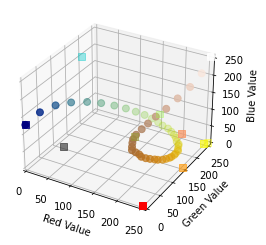

In [4]:
ref_colors = [(0, 0, 128), (0, 200, 200), (250, 250, 0), (150, 250, 50),
              (250, 250, 0), (255, 150, 0), (255, 255, 0), (250, 0 , 0),
              (150, 150, 50), (50, 50, 50), (250, 150, 100), (255, 255, 255)]

print(ref_colors)
num_colors = 3 * 256 // 16

gradient = bezier_gradient(ref_colors, num_colors)
print(gradient)

plot_gradient_series(color_dict(gradient),
                     pointsize=num_colors,
                     control_points=control_points_from_colors(ref_colors)
                    )

In [5]:
def computeACoeff(x1, x2, y1, y2, k):
    return k*(x2 - x1) - (y2 -y1)

def computeBCoeff(x1, x2, y1, y2, k):
    return -k*(x2 - x1) + (y2 -y1)

def findLowerBound(xvalues, x):
    if xvalues[-1] == x:
        return len(xvalues) - 2
    left = bisect_left(xvalues, x)
    if left >= len(xvalues):
        return len(xvalues) - 1
    if (xvalues[left]==x):
        return 0 if left == 0 else left - 1
    return left - 1

class CubicSplineStruct:
    def __init__(self):
        self.m_n = 0
        self.m_xvalues = []
        self.m_yvalues = []
        self.m_kMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_yMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_ytoKMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_kCoeffs = []
    def pushFirstEquationToKMatrix(self, x0, x1):
        self.m_kMatrix[0, 0] = 2./(x1 - x0)
        self.m_kMatrix[0, 1] = 1./(x1 - x0)
    def pushLastEquationToKMatrix(self, xnm1, xn):
        self.m_kMatrix[-1, -1] = 2./(xn - xnm1)
        self.m_kMatrix[-1, -2] = 1./(xn - xnm1)
    def pushMiddleEquationToKMatrix(self, i, xim1, xi, xip1):
        self.m_kMatrix[i, i-1] = 1./(xi - xim1)
        self.m_kMatrix[i, i] = 2./(xi - xim1) + 2./(xip1 - xi)
        self.m_kMatrix[i, i + 1] = 1./(xip1 - xi)
    def computeKMatrix(self):
        self.m_kMatrix = np.matrix(np.zeros(shape=(self.m_n, self.m_n)))
        self.pushFirstEquationToKMatrix(self.m_xvalues[0], self.m_xvalues[1])
        for i in range(1, self.m_n-1):
            self.pushMiddleEquationToKMatrix(i, self.m_xvalues[i-1], self.m_xvalues[i], self.m_xvalues[i+1])
        self.pushLastEquationToKMatrix(self.m_xvalues[-2], self.m_xvalues[-1])
    def pushFirstEquationToYMatrix(self, x0, x1):
        self.m_yMatrix[0, 0] = -3./(x1 - x0)**2
        self.m_yMatrix[0, 1] = 3./(x1 - x0)**2
    def pushLastEquationToYMatrix(self, xnm1, xn):
        self.m_yMatrix[-1, -1] = 3./(xn - xnm1)**2
        self.m_yMatrix[-1, -2] = -3./(xn - xnm1)**2

    def pushMiddleEquationToYMatrix(self, i, xim1, xi, xip1):
        self.m_yMatrix[i, i-1] = -3./(xi - xim1)**2
        self.m_yMatrix[i, i] = 3./(xi - xim1)**2 - 3./(xip1 - xi)**2
        self.m_yMatrix[i, i + 1] = 3./(xip1 - xi)**2
    def computeYMatrix(self):
        self.m_yMatrix = np.matrix(np.zeros(shape=(self.m_n, self.m_n)))
        self.pushFirstEquationToYMatrix(self.m_xvalues[0], self.m_xvalues[1])
        for i in range(1, self.m_n-1):
            self.pushMiddleEquationToYMatrix(i, self.m_xvalues[i-1], self.m_xvalues[i], self.m_xvalues[i+1])
        self.pushLastEquationToYMatrix(self.m_xvalues[-2], self.m_xvalues[-1])
    def computeYtoKMatrix(self):
        self.computeKMatrix()
        self.computeYMatrix()
        self.m_ytoKMatrix = self.m_kMatrix.I*self.m_yMatrix
    def computeKCoeffs(self):
        kCoeffs = np.array(self.m_yvalues)*self.m_ytoKMatrix.T
        self.m_kCoeffs = [kCoeffs[0, i] for i in range(self.m_n)]
    def interpolateOnInterval(self, intervalIndex, x):
        x1 = self.m_xvalues[intervalIndex]
        x2 = self.m_xvalues[intervalIndex+1]
        y1 = self.m_yvalues[intervalIndex]
        y2 = self.m_yvalues[intervalIndex+1]
        t = (x - x1)/(x2 - x1)
        a = computeACoeff(x1, x2, y1, y2, self.m_kCoeffs[intervalIndex])
        b = computeBCoeff(x1, x2, y1, y2, self.m_kCoeffs[intervalIndex+1])
        return (1-t)*y1 + t*y2 + t*(1-t)*(a*(1-t)+b*t)
    def interpolate(self, x):
        if len(self.m_xvalues) == 0:
            return 0.
        intervalLowerBound = findLowerBound(self.m_xvalues, x)
        return self.interpolateOnInterval(intervalLowerBound, x)

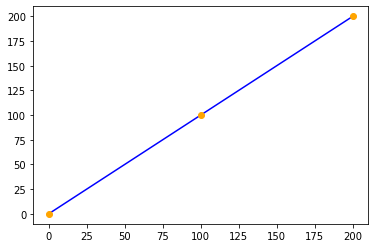

In [6]:
#hlevels_ref_x = [0, 30, 60, 100, 200]
#hlevels_ref_y = [0, 20, 70, 100, 110]

#hlevels_ref_x = [0, 30, 60, 100, 200]
#hlevels_ref_y = [0, 20, 65, 100, 120]

#hlevels_ref_x = [0, 10, 50, 100, 200]
#hlevels_ref_y = [0, 5, 70, 100, 110]

hlevels_ref_x = [0, 100, 200]
hlevels_ref_y = [0, 100, 200]

hlevels_spline = CubicSplineStruct()
hlevels_spline.m_n = len(hlevels_ref_x)
hlevels_spline.m_xvalues =  hlevels_ref_x
hlevels_spline.computeYtoKMatrix()
hlevels_spline.m_yvalues = hlevels_ref_y
hlevels_spline.computeKCoeffs()

x_steps = 10
hlevels_x = [x / x_steps for x in range(min(hlevels_ref_x) * x_steps, max(hlevels_ref_x) * x_steps)]
hlevels_y = [hlevels_spline.interpolate(x) for x in hlevels_x]

plt.plot(hlevels_x, hlevels_y, '-b')
plt.plot(hlevels_ref_x, hlevels_ref_y, 'o', color='orange')
plt.show()

[0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]


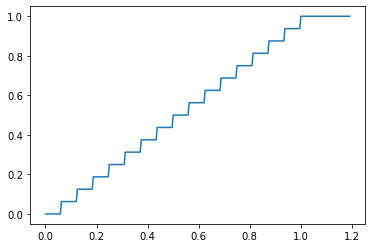

In [14]:
h_steps = 16
step_values = [v / h_steps for v in range(h_steps + 1)]

#step_values = [0., 1.] + [math.atan(2 ** (i * 0.65)) / math.pi * 2. for i in range(-10, 10)]

print(step_values)

def get_step_value(value):
    return max( [v for v in step_values if v <= value] )

x = [i/256 for i in range(256 + 50)]
y = [get_step_value(i) for i in x]
plt.plot(x, y)
plt.show()

#[(i, j) for i, j in zip(x, y)]

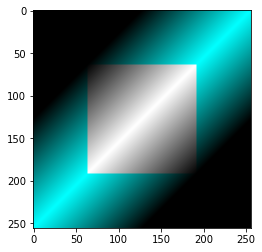

(255, 255, 255, 255)
(255, 255, 255, 255)
(2, 2, 2, 255)
(2, 2, 2, 255)



In [15]:
src_base_l = 64 * 2
src_base_w = src_base_l
src_base_h = src_base_l
border = src_base_l // 2

h0 = src_base_w / 2. + border - 0.5
v0 = src_base_h / 2. + border - 0.5

def generate_tile_data(pixels, points, hbase=0, vbase=0):
    pA, pB, pC, pD = points

    hmap = np.zeros((src_base_w + border * 2, src_base_h + border * 2))
    for voff in range(src_base_h + 2*border):
        for hoff in range(src_base_w + 2*border):
            ur = (float(hoff) - h0) / float(src_base_w)
            vr = (float(voff) - v0) / float(src_base_h)

            d_t = ur + vr
            d_l = 1 + ur - vr
            if d_t < 0:
                #hlevel = d_l
                #hlevel = - d_t * 2
                hlevel = 2 * pA + (pB - pA) * d_l - (pC - pA - pB / 2) * d_t * 2
            else:
                #hlevel = d_l
                #hlevel = + d_t * 2
                hlevel = 2 * pA + (pB - pA) * d_l + (pD - pA - pB / 2) * d_t * 2

#                hlevel = (pA + (pB - pA) * d_l) * 0 + 2 - (pC - (pA + pB) / 2.) * d_t
#                hlevel = (pA + (pB - pA) * d_l) * 0 + 2 + (pD - (pA + pB) / 2.) * d_t

            hmap[hoff, voff] = hlevel / 4
            hlevel = min(2, max(0, hlevel / 2))
        
            if hoff >= border and hoff < src_base_w + border and \
               voff >= border and voff < src_base_h + border:
                r, g, b = hlevel * 128, hlevel * 128, hlevel * 128
            else:
                r, g, b = hlevel * 0, hlevel * 128, hlevel * 128

            pixels[hbase + hoff, vbase + voff] = ( int(r), int(g), int(b), int(255) )

    return hmap
            
points = (2, 2, 1, 1)
vbase = 0
hbase = 0

img = Image.new('RGBA', (src_base_w + border * 2, src_base_h + border * 2), (0, 0, 0, 0))
pixels = img.load()
hmap = generate_tile_data(pixels, points, hbase, vbase)
plt.imshow(img)
plt.show()

print(img.getpixel((0 + border, src_base_h + border - 1)))
print(img.getpixel((src_base_w + border - 1, 0 + border)))
print(img.getpixel((0 + border, 0 + border)))
print(img.getpixel((src_base_w + border - 1, src_base_h + border - 1)))

print('')


In [16]:
def generate_full_tile_data(pixels, code):
    points = (0, 2, 1, 1)
    return generate_tile_data(pixels, points)

def generate_images(code):
    img = Image.new('RGBA', (src_base_w + border * 2, src_base_h + border * 2), (0, 0, 0, 0))
    pixels = img.load()

    hmap = generate_full_tile_data(pixels, code)
    shape = (src_base_w + border * 2, src_base_h + border * 2)
    lin_x = np.linspace(0, 1, shape[0], endpoint=False)
    lin_y = np.linspace(0, 1, shape[1], endpoint=False)
    x, y = np.meshgrid(lin_x, lin_y)
    grady, gradx = np.gradient(hmap, .2, .2)

    W = src_base_w
    H = src_base_h * 23 // 32
    FullH = H * 2
    max_v = 255
    inc_z = 64

    #h_steps = 8

    cos45deg = math.sqrt(2.) / 2.

    c_img = Image.new('RGBA', (W, FullH), (0, 0, 0, 0))
    c_pixels = c_img.load()

    n_img = Image.new('RGBA', (W, FullH), (128, 128, 255, 255))
    n_pixels = n_img.load()

    z_img = Image.new('RGBA', (W, FullH), (0, 0, 0, 0))
    z_pixels = z_img.load()

    x0, y0 = 0, 0
    w, h = c_img.size[0], c_img.size[1]
    hpos, vpos = border, border
    for ry in range(src_base_h):
        y = src_base_h - ry - 1  
        for x in range(src_base_w):
            hoff = hpos # * src_base_w
            voff = vpos # * src_base_h
            sx = x + hoff
            sy = voff + src_base_h - y

            try:
                h = min(1, max(0, hmap[sx, sy]))
                h = hlevels_spline.interpolate(h * 100.0) / 100.0
                rv, gv, bv, av = int(h * 255), int(h * 255), int(h * 255), 255
                #rv, gv, bv, av = img.getpixel((sx, sy))
            except:
                print(f"hoff={hoff}, voff={voff}, x={x}, y={y}, sx={sx}, sy={sy}, "
                      f"src_base_w={src_base_w}, src_base_h={src_base_h}")
                raise

            v = max(rv, gv, bv, 2)

            if v > 1:
                #tv = v / max_v
                #tv = int( v / max_v * h_steps ) / h_steps
                tv = get_step_value(v / max_v)
                
                cv = tv * 15
                r, g, b = gradient[int(cv)]
                r, g, b = int(r * .8), int(g * .8), int(b * .8)

                v = int(tv * H)
                for iv in range(0, v):
                    cf = .3 + .3 * iv / v                 
                    c_pixels[x0 + x, (FullH - 1) - (y0 + (y + iv) * H / W)] = \
                        (int(r*cf), int(g*cf), int(b*cf), 255)


                    dx = hmap[sx + 1, sy] - hmap[sx - 1, sy]
                    dy = hmap[sx, sy + 1] - hmap[sx, sy - 1]
                    dxy = math.sqrt(dx*dx + dy*dy)
                    if dxy:
                        dx = dx / dxy ; dy = dy / dxy
                        if dx < 0: ang = -math.acos(-dy)
                        else: ang = math.acos(-dy) 
                        normal = [ math.sin(ang), math.cos(ang), 0 ]
                    else:
                        normal = [ 0, 0 ]

                    if ry == src_base_h - 1:
                        normal = [ 0, 1 ]
                
                    mn = math.sqrt( normal[0] * normal[0] + normal[1] * normal[1] )
                    if mn < 0.01: normal = (0, 0, 1)
                    else:         normal = (normal[0] / mn, normal[1] / mn, 0)

                    nr = normal[0]
                    ng = (normal[2] - normal[1]) * cos45deg
                    nb = (normal[1] + normal[2]) * cos45deg
                    n_pixels[x0 + x, (FullH - 1) - (y0 + (y + iv) * H / W)] = (
                        int(128 + 127 * nr), int(128 + 127 * ng), int(255 * nb), 255
                    )

                    z = iv / H - y / src_base_h
                    z_pixels[x0 + x, (FullH - 1) - (y0 + (y + iv) * H / W)] = (
                        int(128 + z * inc_z), int(128 + z * inc_z), int(128 + z * inc_z), 255
                    )
                
                c_pixels[x0 + x, (FullH - 1) - (y0 + (y + v) * H / W)] = (r, g, b, 255)

                normal = (0, 0, 1)
                nr = normal[0]
                ng = (normal[2] - normal[1]) * cos45deg
                nb = (normal[1] + normal[2]) * cos45deg
                #mn = math.sqrt( normal[0] * normal[0] + normal[1] * normal[1] + normal[2] * normal[2] )
                #print(normal, mn, nr, ng, nb)
                n_pixels[x0 + x, (FullH - 1) - (y0 + (y + v) * H / W)] = (
                    int(128 + 127 * nr), int(128 + 127 * ng), int(255 * nb), 255
                )

                z = v / H - y / src_base_h
                z_pixels[x0 + x, (FullH - 1) - (y0 + (y + v) * H / W)] = (
                    int(128 + z * inc_z), int(128 + z * inc_z), int(128 + z * inc_z), 255
                )

    return hmap, img, c_img, n_img, z_img

Code 000001011 ( 11 / 0x0B)


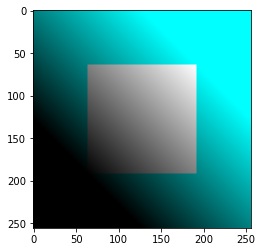

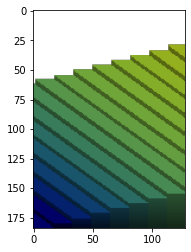

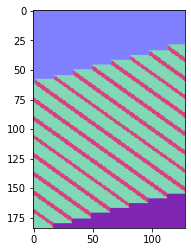

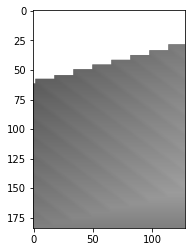

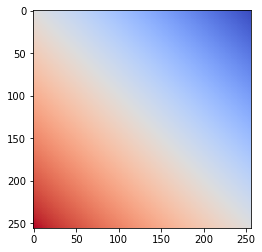

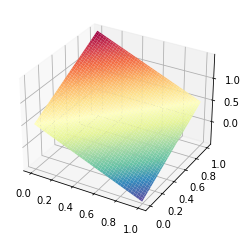

In [17]:
tile_width  = src_base_w
tile_height = ( src_base_h * 23 // 32 ) * 2

c_img = Image.new('RGBA', (tile_width, tile_height), (0, 0, 0, 0) )
c_pixels = c_img.load()
n_img = Image.new('RGBA', (tile_width, tile_height), (0, 0, 0, 0) )
n_pixels = n_img.load()
z_img = Image.new('RGBA', (tile_width, tile_height), (0, 0, 0, 0) )
z_pixels = n_img.load()

for code in [ 0x0B ]:
    hbase = 0
    vbase = 0

    print(f"Code {code:>09b} ({code:3} / 0x{code:02X})")

    hmap, img, c_img, n_img, z_img = generate_images(code)

    plt.imshow(img)
    plt.show()

    plt.imshow(c_img)
    plt.show()

    plt.imshow(n_img)
    plt.show()

    plt.imshow(z_img)
    plt.show()

    shape = (src_base_w + border * 2, src_base_h + border * 2)

    # See: https://jackmckew.dev/3d-terrain-in-python.html

    plt.imshow(hmap, cmap=cm.coolwarm, interpolation='none')

    # For plotting this in 3 dimensions, we must initialise 2 more arrays which will
    # contain the x-y co-ordinates of our world.

    lin_x = np.linspace(0, 1, shape[0], endpoint=False)
    lin_y = np.linspace(0, 1, shape[1], endpoint=False)
    x, y = np.meshgrid(lin_x, lin_y)

    # Now it's time to plot in 3D with matplotlib

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x, y, hmap, cmap=cm.Spectral_r)
